# Aligning heart ST data from ISS

Serial sections of 6.5 PCW human heart from the Human Cell Atlas https://doi.org/10.1016/j.cell.2019.11.025

In [1]:
# import dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

# make plots bigger
plt.rcParams["figure.figsize"] = (12,10)

In [ ]:
# OPTION A: import STalign after pip or pipenv install
from STalign import STalign

In [2]:
## OPTION B: skip cell if installed STalign with pip or pipenv
import sys
sys.path.append("../../STalign") 

## import STalign from upper directory
import STalign

We have already downloaded single cell spatial transcriptomics datasets and placed the files in a folder called `data_data`.

We can read in the cell information for the first dataset using `pandas` as `pd`.

In [3]:
# Single cell data 1
# read in data
fname = '../heart_data/CN73_E1.csv.gz'
df1 = pd.read_csv(fname)
print(df1.head())

   Unnamed: 0             x             y   intensity  area  id    color  \
0           1   9220.548828  27954.275391  126.357140    34 NaN  #000000   
1           2  16412.062500  27723.751953  170.324326    86 NaN  #000000   
2           3  16451.130859  27567.246094  170.600006    46 NaN  #000000   
3           4  18739.607422  27238.117188  170.125000    34 NaN  #000000   
4           5  18713.855469  27219.013672  171.300003    46 NaN  #000000   

  acronym  right.left  rostral.caudal  spot.id    image  
0     NaN  -58.104428      775.168105      NaN  CN73_E1  
1     NaN  127.199485      775.176714      NaN  CN73_E1  
2     NaN  132.844121      775.176714      NaN  CN73_E1  
3     NaN  216.521727      775.176714      NaN  CN73_E1  
4     NaN  216.521080      775.176714      NaN  CN73_E1  


For alignment with `STalign`, we only need the cell centroid information. So we can pull out this information. We can further visualize the cell centroids to get a sense of the variation in cell density that we will be relying on for our alignment by plotting using `matplotlib.pyplot` as `plt`. 

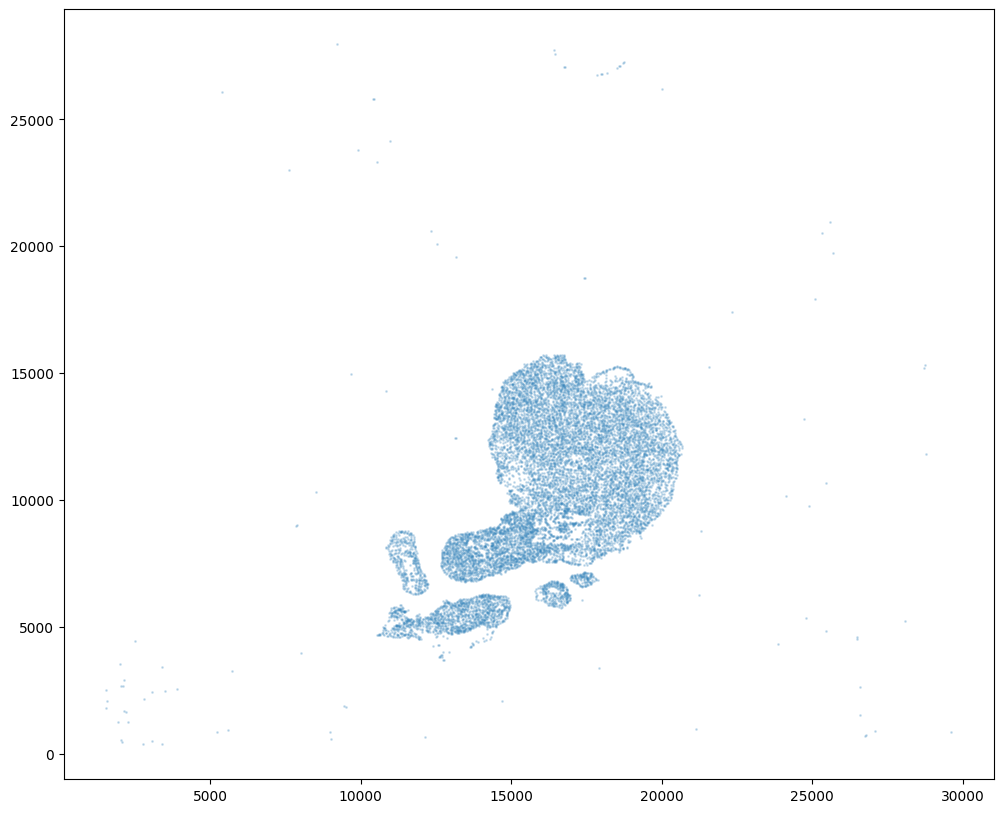

In [4]:
# get cell centroid coordinates
xI = np.array(df1['x'])
yI = np.array(df1['y'])

# plot
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=1,alpha=0.2)

We will first use `STalign` to rasterize the single cell centroid positions into an image. Assuming the single-cell centroid coordinates are in microns, we will perform this rasterization at a 100 micron resolution. We can visualize the resulting rasterized image.

Note that points are plotting with the origin at bottom left while images are typically plotted with origin at top left so we've used `invert_yaxis()` to invert the yaxis for visualization consistency. 

0 of 12183
10000 of 12183
12182 of 12183


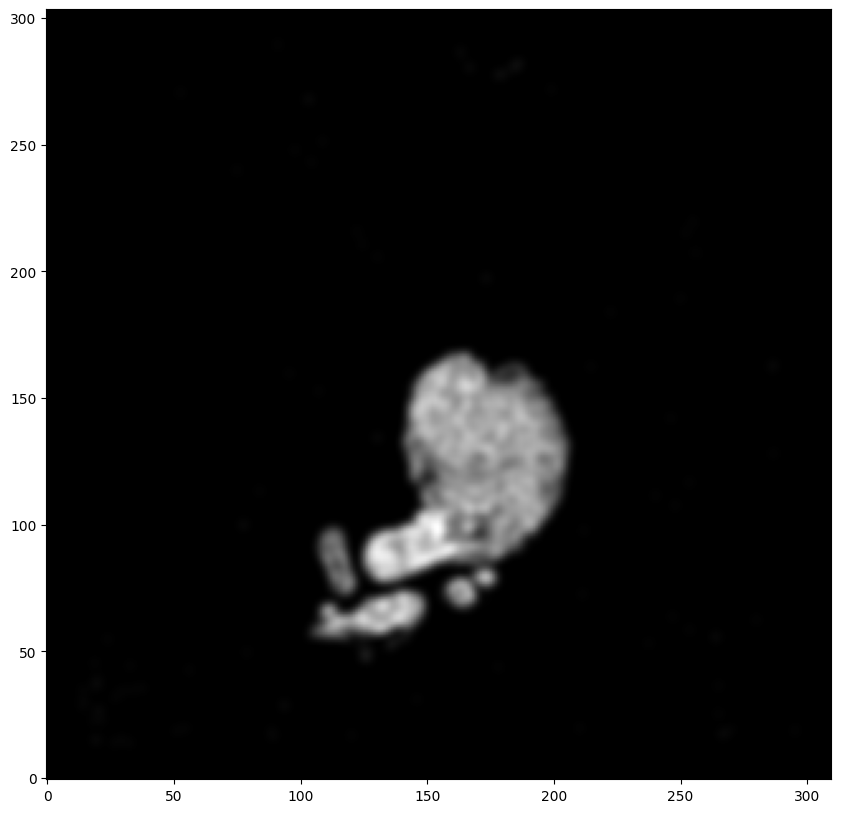

In [5]:
# rasterize at 100um resolution so image looks smooth
XI,YI,I,fig = STalign.rasterize(xI,yI,dx=100)

# plot
ax = fig.axes[0]
ax.invert_yaxis()

Now, we can repeat this for the cell information from the second dataset.

In [6]:
# Single cell data 2
# read in data
fname = '../heart_data/CN73_E2.csv.gz'
df2 = pd.read_csv(fname, skiprows=[1]) # first row is data type
print(df2.head())

   Unnamed: 0             x             y   intensity  area  id    color  \
0       12185   3965.500000  26604.583984  178.437500    32 NaN  #000000   
1       12186    902.051270  26600.513672  151.615387    26 NaN  #000000   
2       12187   3949.748047  26560.296875  156.199997    90 NaN  #000000   
3       12188   6231.878906  26551.273438  152.812500    22 NaN  #000000   
4       12189  12881.071289  26510.095703  197.307693   112 NaN  #000000   

  acronym  right.left  rostral.caudal  spot.id    image  
0     NaN -459.896378     1097.377561      NaN  CN73_E2  
1     NaN -643.887328     1104.877930      NaN  CN73_E2  
2     NaN -461.396305     1094.377414      NaN  CN73_E2  
3     NaN -324.403043     1089.877192     31.0  CN73_E2  
4     NaN   95.076323     1098.877635     10.0  CN73_E2  


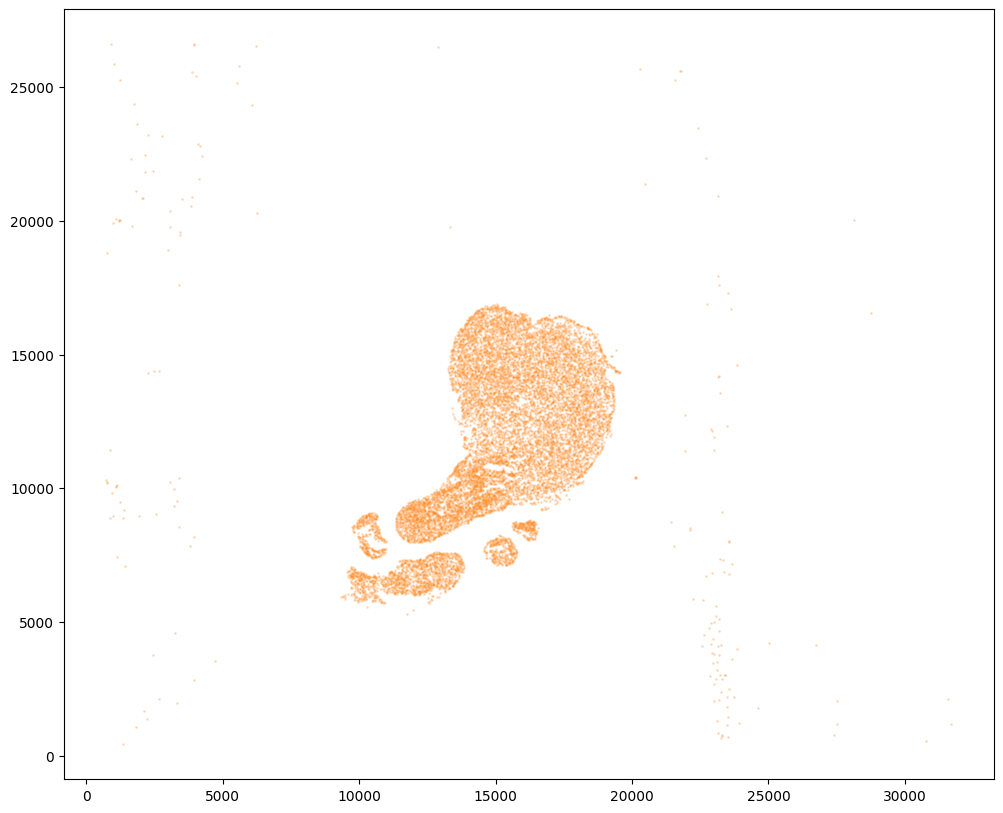

In [7]:
# get cell centroids
xJ = np.array(df2['x'])
yJ = np.array(df2['y'])

# plot
fig,ax = plt.subplots()
ax.scatter(xJ,yJ,s=1,alpha=0.2,c='#ff7f0e')

0 of 11770
10000 of 11770
11769 of 11770


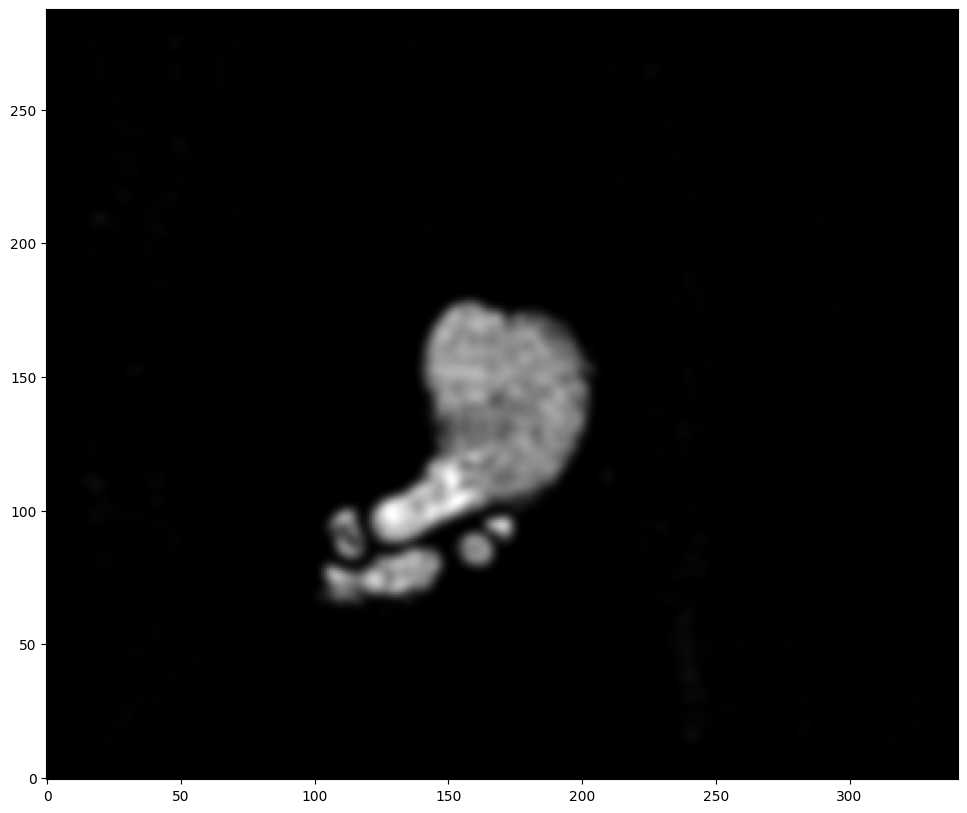

In [8]:
# rasterize and plot
XJ,YJ,J,fig = STalign.rasterize(xJ,yJ,dx=100)
ax = fig.axes[0]
ax.invert_yaxis()

Note that plotting the cell centroid positions from both datasets shows that non-linear local alignment is needed.

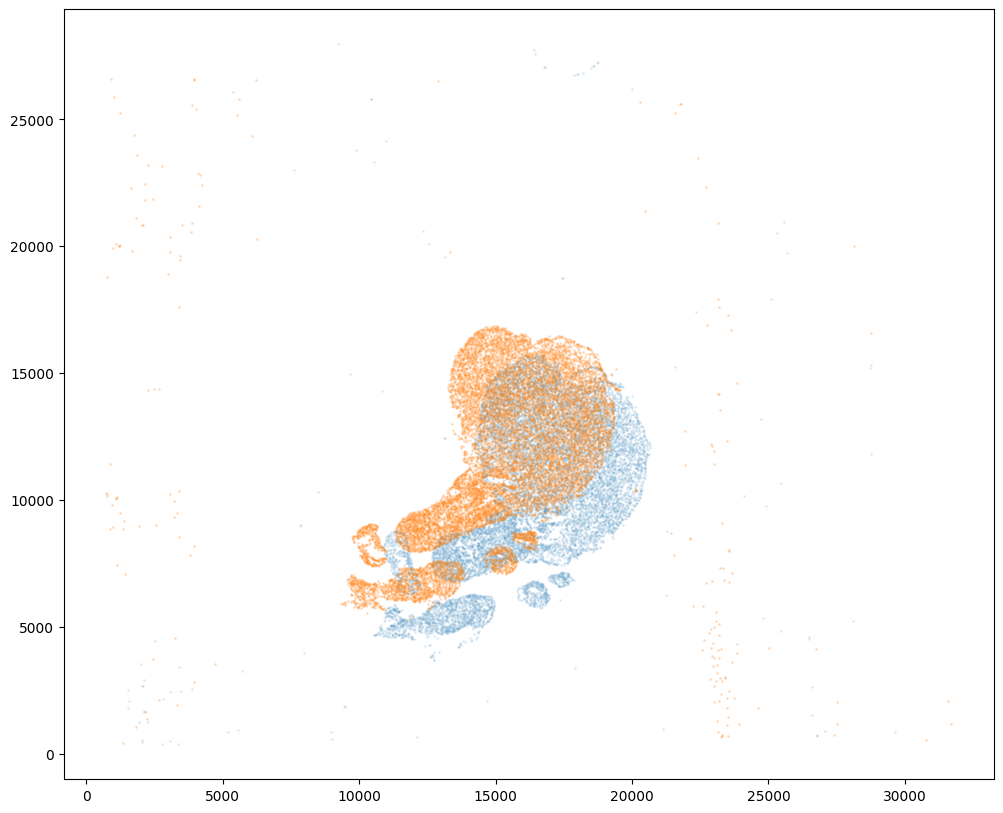

In [9]:
# plot
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=1,alpha=0.1)
ax.scatter(xJ,yJ,s=1,alpha=0.2)

We can also plot the rasterized images next to each other.

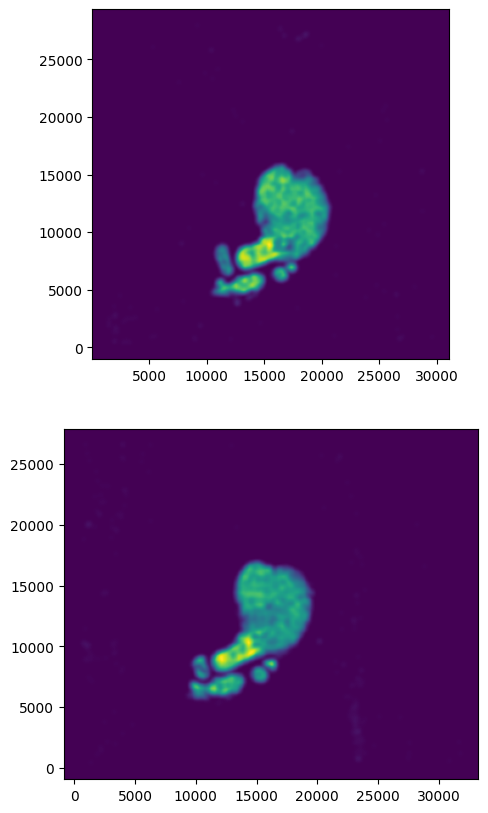

In [10]:
# get extent of images
extentI = STalign.extent_from_x((YI,XI))
extentJ = STalign.extent_from_x((YJ,XJ))

# plot rasterized images
fig,ax = plt.subplots(2,1)
ax[0].imshow((I.transpose(1,2,0).squeeze()), extent=extentI) 
ax[1].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ) 
ax[0].invert_yaxis()
ax[1].invert_yaxis()

Now we will perform our alignment. There are many parameters that can be tuned for performing this alignment. If we don't specify parameters, defaults will be used. 

In [11]:
# set device for building tensors
if torch.cuda.is_available():
    torch.set_default_device('cuda:0')
else:
    torch.set_default_device('cpu')

/home/kalen/.local/share/virtualenvs/STalign-VWNsoi3D/lib/python3.8/site-packages/torch/utils/_device.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/kalen/.local/share/virtualenvs/STalign-VWNsoi3D/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/kalen/STalign/docs/notebooks/../../STalign/STalign.py:1301: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axE[2].set_yscale('log')
/home/kalen/.local/share/virtualenvs/STalign-VWNsoi3D/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encou

CPU times: user 3min 42s, sys: 35 s, total: 4min 17s
Wall time: 2min 4s


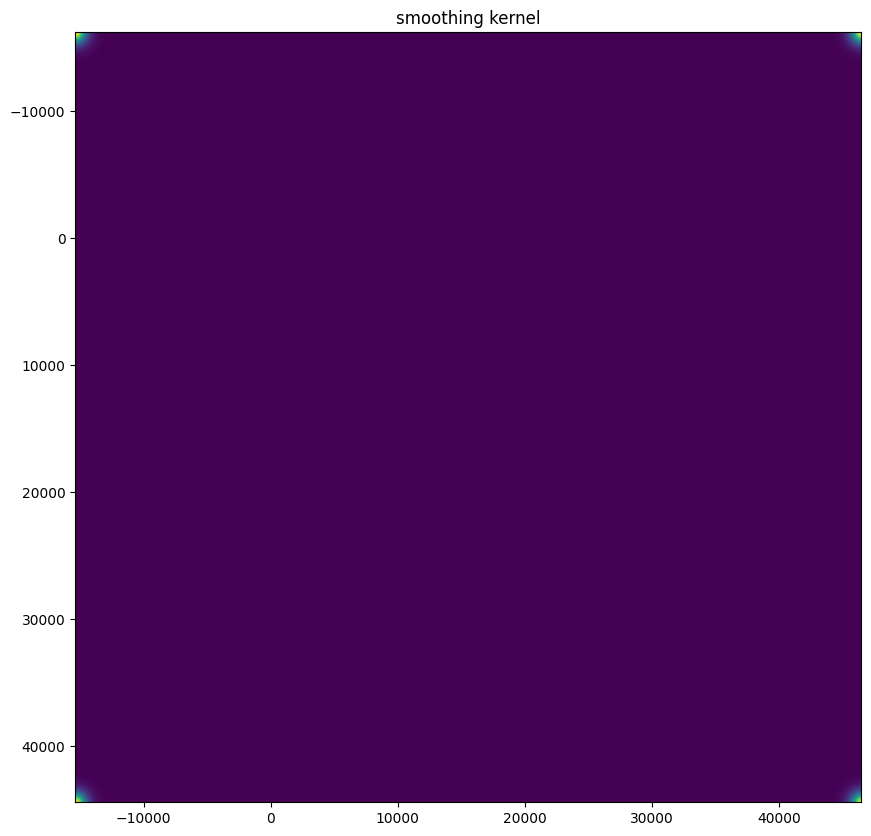

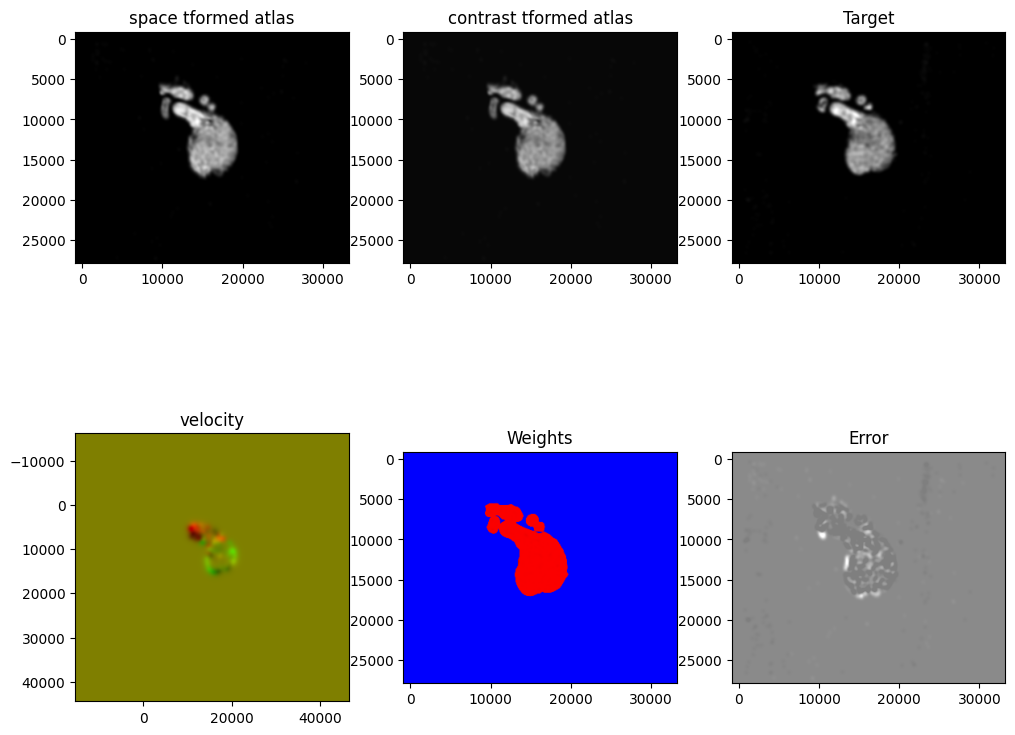

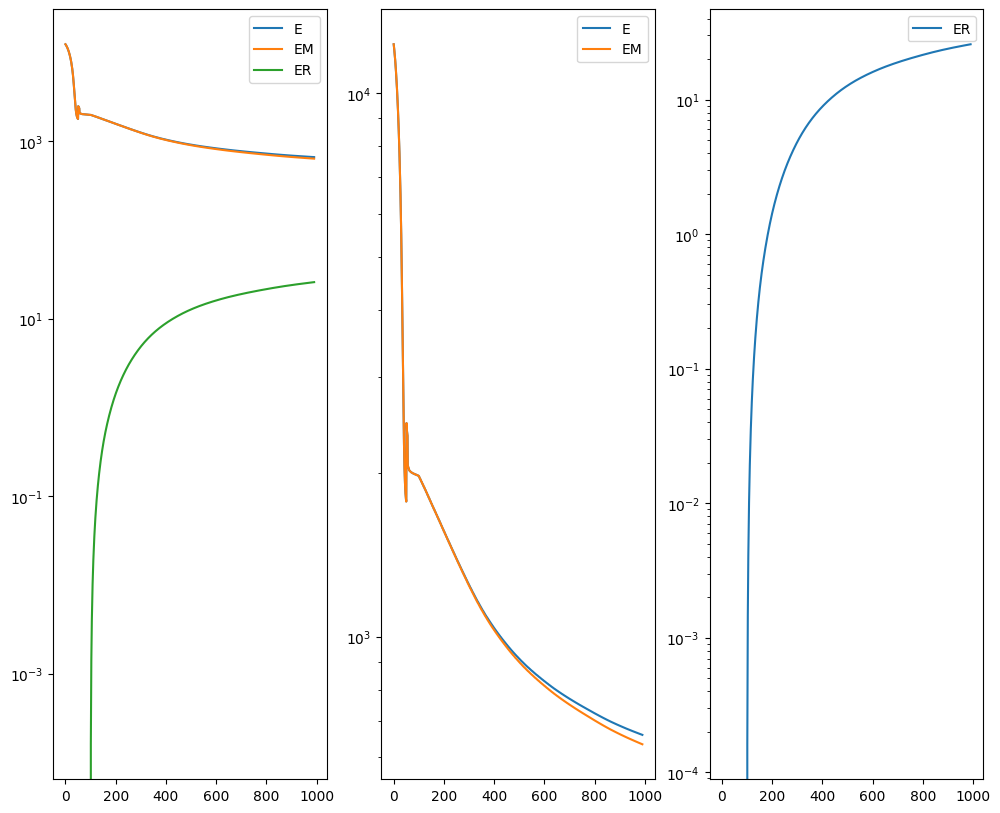

In [12]:
%%time 

# run LDDMM
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

# keep all other parameters default
params = {
          'niter':1000,
          'device':device,
          'diffeo_start':100,
          'a':250,
          'epV':1000,
          'sigmaB':0.1,
          'muB': torch.tensor([0,0,0]), # black is background in target
          }

Ifoo = np.vstack((I, I, I)) # make RGB instead of greyscale
Jfoo = np.vstack((J, J, J)) # make RGB instead of greyscale
out = STalign.LDDMM([YI,XI],Ifoo,[YJ,XJ],Jfoo,**params)

In [13]:
# get necessary output variables
A = out['A']
v = out['v']
xv = out['xv']

Plots generated throughout the alignment can be used to give you a sense of whether the parameter choices are appropriate and whether your alignment is converging on a solution.

We can also evaluate the resulting alignment by applying the transformation to visualize how our source and target images were deformed to achieve the alignment. 

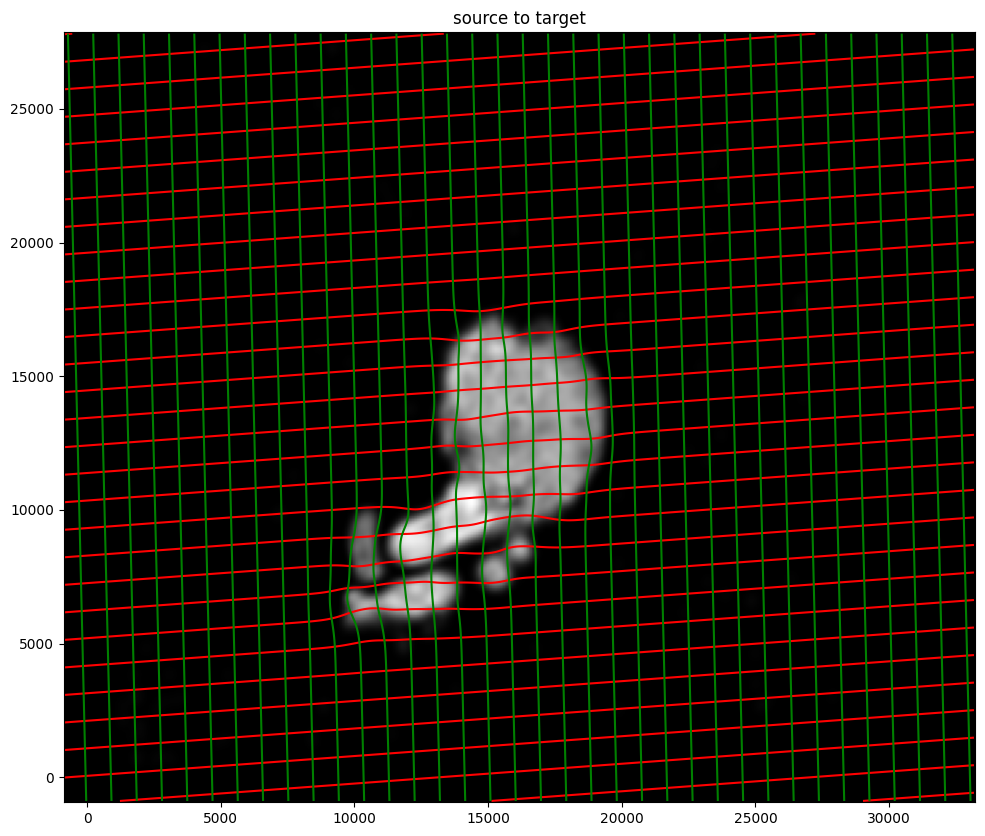

In [14]:
# apply transform
phii = STalign.build_transform(xv,v,A,XJ=[YJ,XJ],direction='b')
phiI = STalign.transform_image_atlas_to_target(xv,v,A,[YI,XI],Ifoo,[YJ,XJ])


#switch tensor from cuda to cpu for plotting with numpy
if phii.is_cuda:
    phii = phii.cpu()
if phiI.is_cuda:
    phiI = phiI.cpu()

# plot with grids
fig,ax = plt.subplots()
levels = np.arange(-100000,100000,1000)
ax.contour(XJ,YJ,phii[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XJ,YJ,phii[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('source to target')
ax.imshow(phiI.permute(1,2,0)/torch.max(phiI),extent=extentJ)
ax.invert_yaxis()

Note that because of our use of LDDMM, the resulting transformation is invertible.

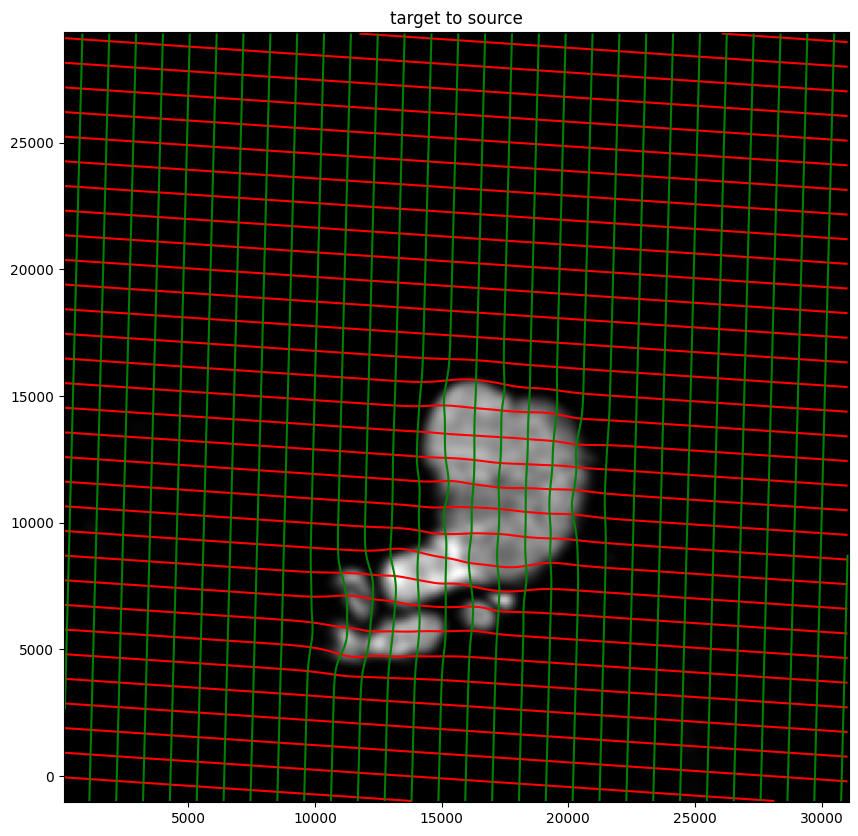

In [15]:
# transform is invertible
phi = STalign.build_transform(xv,v,A,XJ=[YI,XI],direction='f')
phiiJ = STalign.transform_image_target_to_atlas(xv,v,A,[YJ,XJ],Jfoo,[YI,XI])

#switch tensor from cuda to cpu for plotting with numpy
if phi.is_cuda:
    phi = phi.cpu()
if phiiJ.is_cuda:
    phiiJ = phiiJ.cpu()

# plot with grids
fig,ax = plt.subplots()
levels = np.arange(-100000,100000,1000)
ax.contour(XI,YI,phi[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XI,YI,phi[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('target to source')
ax.imshow(phiiJ.permute(1,2,0)/torch.max(phiiJ),extent=extentI)
ax.invert_yaxis()

Finally, we can apply our transform to the original sets of single cell centroid positions to achieve their new aligned positions.

In [16]:
# apply transform to original points
tpointsJ = STalign.transform_points_target_to_atlas(xv,v,A, np.stack([yJ, xJ], 1))

#switch tensor from cuda to cpu for plotting with numpy
if tpointsJ.is_cuda:
    tpointsJ = tpointsJ.cpu()

# just original points for visualizing later
tpointsI = np.stack([xI, yI]) 

And we can visualize the results.

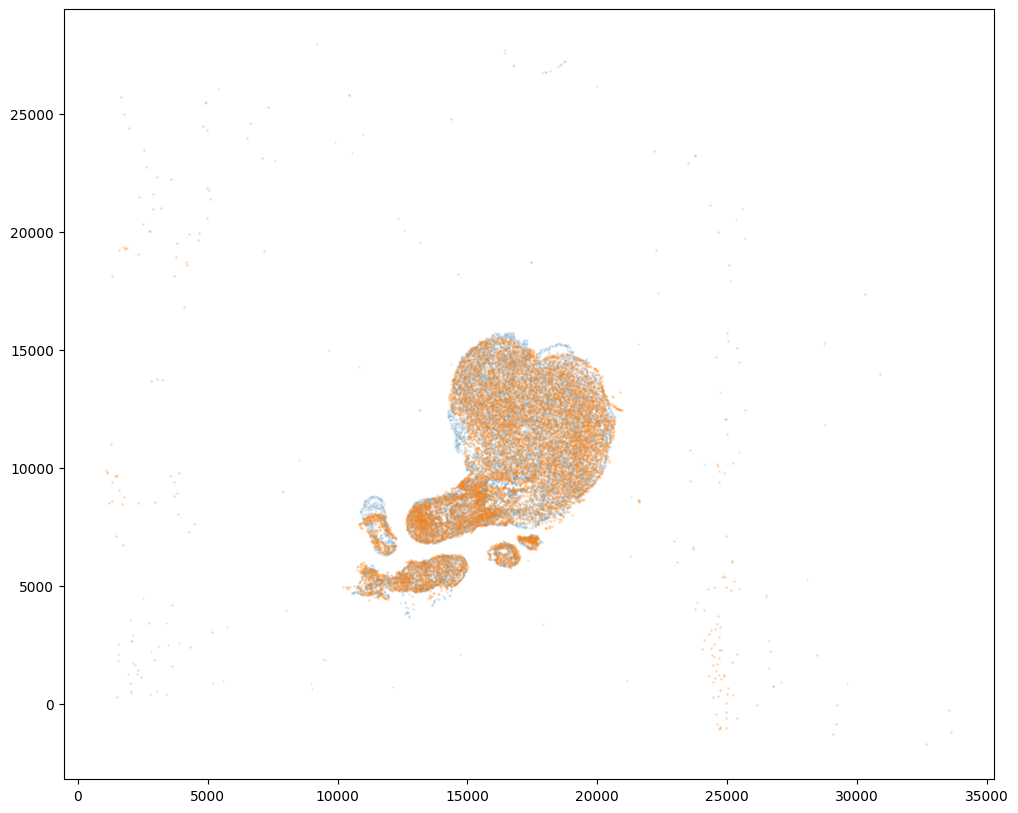

In [17]:
# plot results
fig,ax = plt.subplots()
ax.scatter(tpointsI[0,:],tpointsI[1,:],s=1,alpha=0.1) 
ax.scatter(tpointsJ[:,1],tpointsJ[:,0],s=1,alpha=0.2) # also needs to plot as y,x not x,y

In [18]:
# save results
results = tpointsJ.numpy()

In [ ]:
results.to_csv('../heart_data/CN73_E1_to_CN73_E2.csv.gz',
               compression='gzip')